## Task 3 – Model Explainability using SHAP

This notebook explains the predictions of the best-performing Random Forest model
using SHAP to understand key drivers of fraud detection and derive actionable insights.


### import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load trained model and test data

In [ ]:
# Load trained Random Forest pipeline
rf_pipeline = joblib.load(rC:\Users\Dell\Pictures\fraud-detection\models\random_forest.pkl")

rf_pipeline

# Load processed data
fraud_df = pd.read_csv(r"C:\Users\Dell\Pictures\fraud-detection\data\processed\fraud_data_processed.csv")

TARGET = "class"
X = fraud_df.drop(columns=[TARGET])
y = fraud_df[TARGET]

# Drop columns not used in training
DROP_COLS = ["signup_time", "purchase_time", "device_id", "ip_address"]
X = X.drop(columns=DROP_COLS, errors="ignore")


### Extract Pipeline Components

In [ ]:
# Extract fitted components
preprocessor = rf_pipeline.named_steps["preprocessor"]
rf_model = rf_pipeline.named_steps["model"]

# Transform features
X_transformed = preprocessor.transform(X)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

print(X_transformed.shape)
print(len(feature_names))


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


(151112, 18)
18


### Feature Importance Baseline (Random Forest)

##### Top 10 Important Features

In [ ]:
importances = rf_model.feature_importances_

fi_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

top10 = fi_df.head(10)
top10


,feature,importance
3,num__time_since_signup,0.827842
0,num__user_id,0.036292
1,num__purchase_value,0.033575
2,num__age,0.029897
4,num__hour_of_day,0.024883
5,num__day_of_week,0.015985
8,cat__source_Direct,0.004908
15,cat__sex_F,0.003425
16,cat__sex_M,0.003382
9,cat__source_SEO,0.003119


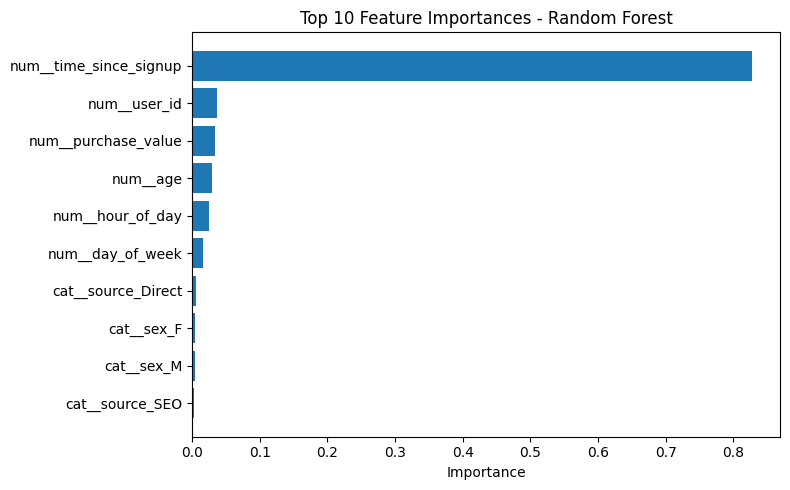

In [ ]:
plt.figure(figsize=(8, 5))
plt.barh(top10["feature"], top10["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

### SHAP Analysis – Global Explanation

#### SHAP Summary Plot

c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Transformed shape: (500, 18)
Number of feature names: 18


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4684\381823571.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_sample_df)
c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. 

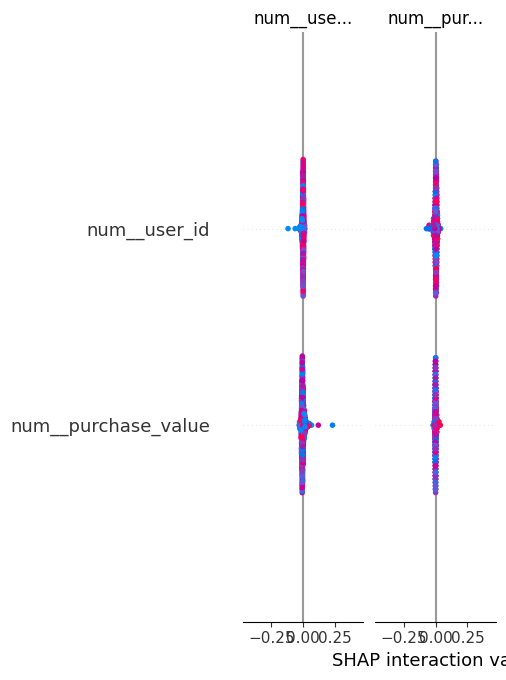

In [ ]:
### SHAP Analysis – Global Explanation 
# Subsample raw data for SHAP
np.random.seed(42)
sample_size = min(500, X.shape[0])
sample_idx = np.random.choice(X.shape[0], size=sample_size, replace=False)
X_sample_raw = X.iloc[sample_idx]

# Transform the sample using pipeline preprocessor
X_sample_transformed = preprocessor.transform(X_sample_raw)

# Convert transformed array to DataFrame with proper column names
feature_names_transformed = preprocessor.get_feature_names_out()
X_sample_df = pd.DataFrame(X_sample_transformed, columns=feature_names_transformed)

# Verify shape
print("Transformed shape:", X_sample_df.shape)
print("Number of feature names:", len(feature_names_transformed))

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer(X_sample_df)

# SHAP summary plot (global feature importance)
shap.summary_plot(shap_values.values, X_sample_df)


### SHAP Analysis – Individual Predictions (Force Plots)
We generate force plots for:
- One True Positive (TP)
- One False Positive (FP)
- One False Negative (FN)


In [ ]:
### SHAP Analysis – Individual Predictions (Force Plots)
# Sample corresponding y values
y_sample_raw = y.iloc[sample_idx]

# Predict on the sample
y_pred_sample = rf_model.predict(X_sample_df)

# Find indices for TP, FP, FN
tp_idx = np.where((y_pred_sample == 1) & (y_sample_raw.values == 1))[0][0]
fp_idx = np.where((y_pred_sample == 1) & (y_sample_raw.values == 0))[0][0]
fn_idx = np.where((y_pred_sample == 0) & (y_sample_raw.values == 1))[0][0]

# Class index for fraud (1)
class_idx = 1

c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


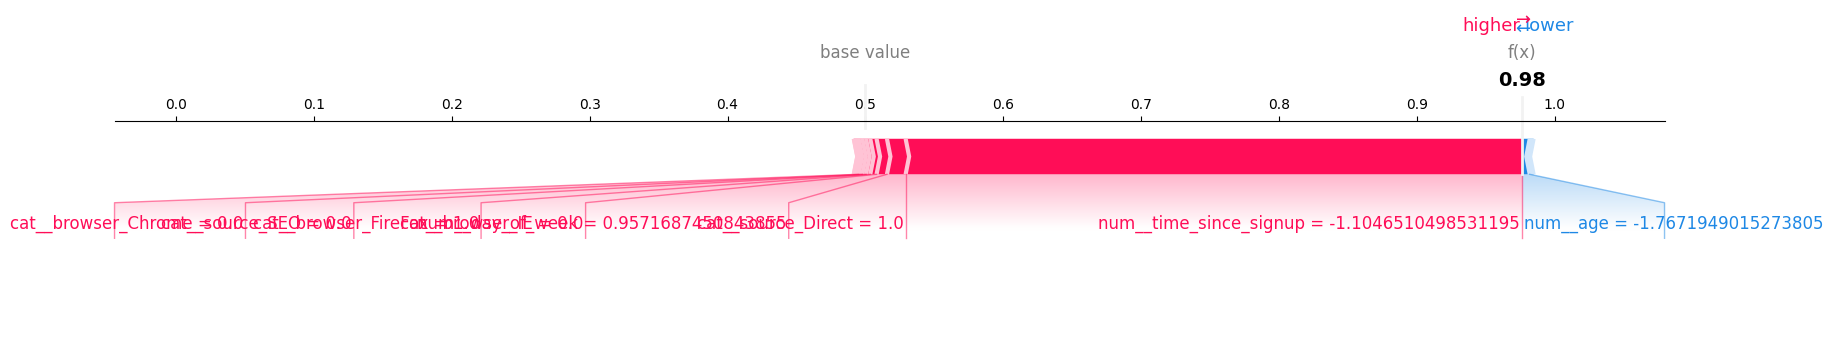

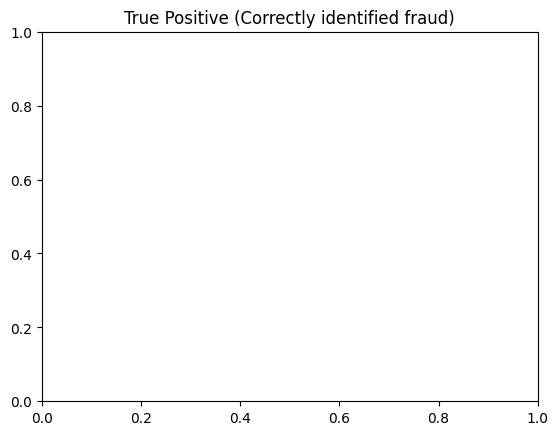

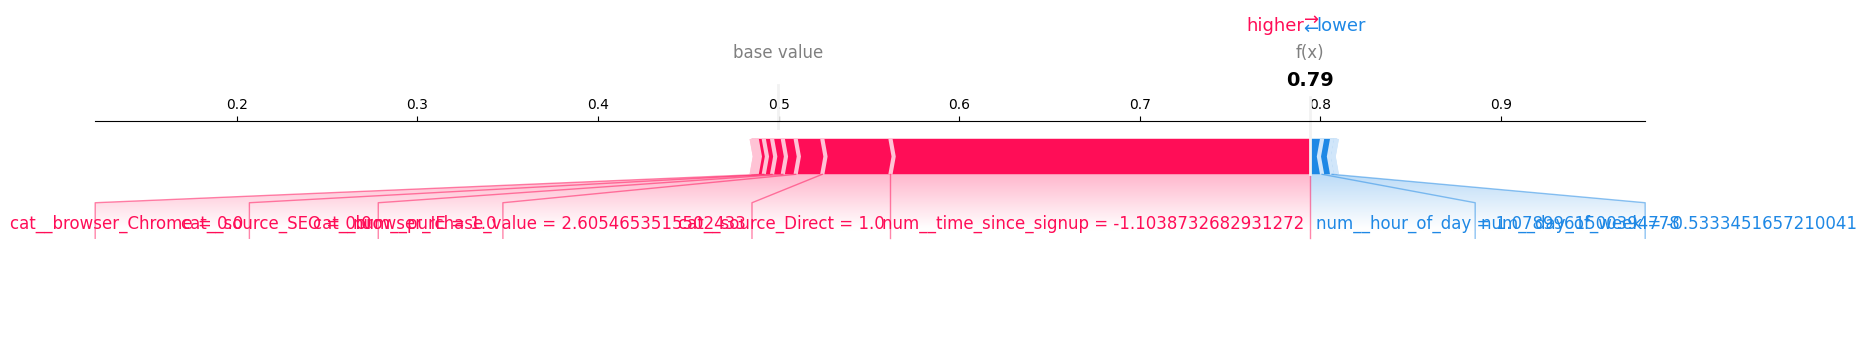

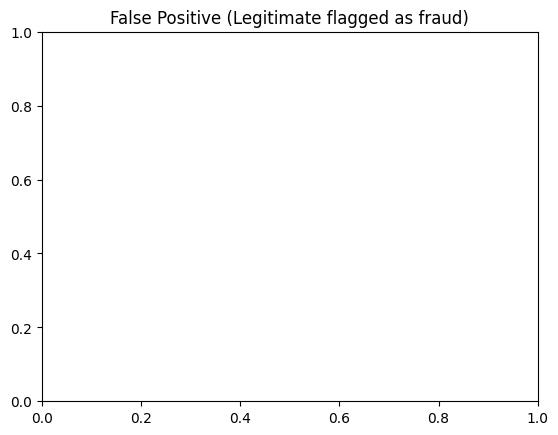

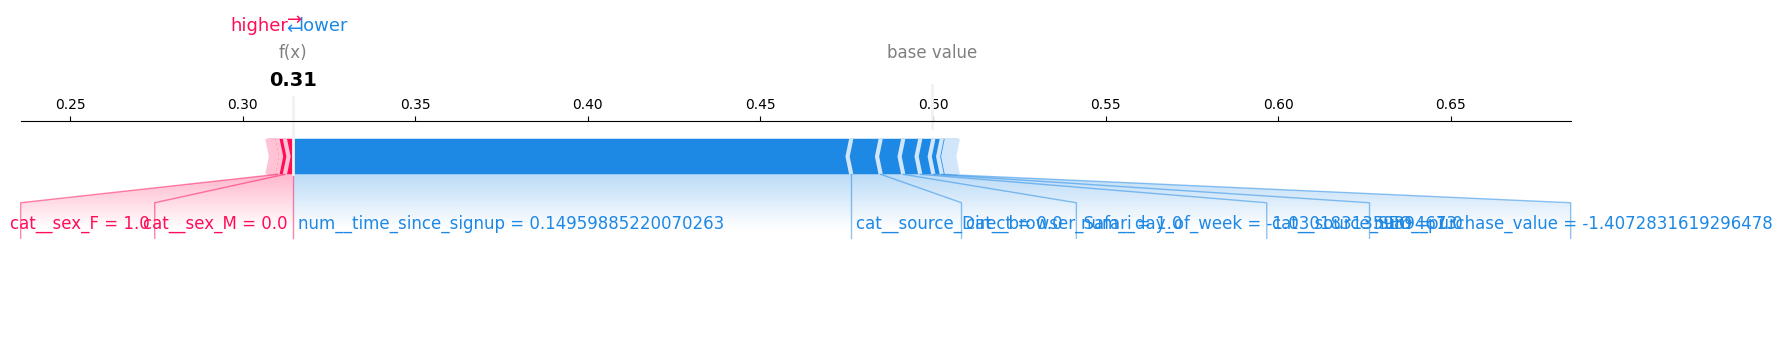

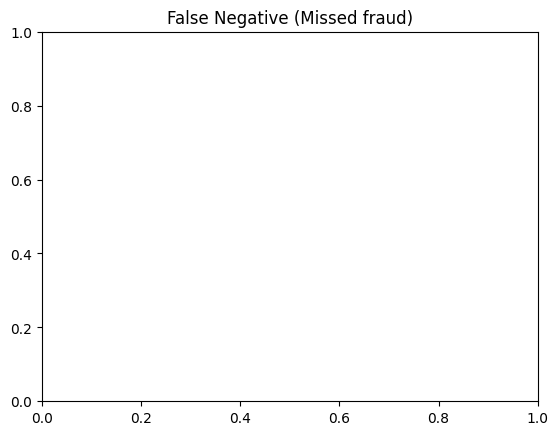

In [ ]:
import shap
shap.initjs()

def plot_force(idx, title):
    """Generate SHAP force plot for a given sample index."""
    # For multi-class, shap_values[idx] gives array of shape (num_features, num_classes)
    # We pick the class index for fraud (1)
    shap.force_plot(
        explainer.expected_value[class_idx],
        shap_values[idx][:, class_idx] if shap_values.ndim == 3 else shap_values[idx],
        X_sample_df.iloc[idx],
        matplotlib=True
    )
    plt.title(title)
    plt.show()

# Plot force plots
plot_force(tp_idx, "True Positive (Correctly identified fraud)")
plot_force(fp_idx, "False Positive (Legitimate flagged as fraud)")
plot_force(fn_idx, "False Negative (Missed fraud)")


### Interpretation

In [ ]:
# shap_values already computed on transformed features
if isinstance(shap_values, list):
    shap_array = shap_values[class_idx]  # multi-class
else:
    shap_array = shap_values  # binary

# Ensure 2D array
shap_array = np.atleast_2d(shap_array)

# Compute mean absolute SHAP per transformed feature
# Flatten any extra dimensions to make sure it's 1D
shap_abs_mean = np.mean(np.abs(shap_array), axis=0)
shap_abs_mean = np.array([np.mean(v) if np.ndim(v) > 0 else v for v in shap_abs_mean])

# Get expanded feature names
feature_names_transformed = preprocessor.get_feature_names_out()

# Ensure lengths match
assert shap_abs_mean.shape[0] == len(feature_names_transformed), \
    f"Feature count mismatch: {shap_abs_mean.shape[0]} vs {len(feature_names_transformed)}"

# Create DataFrame
shap_feature_importance = pd.DataFrame({
    "feature": feature_names_transformed,
    "shap_importance": shap_abs_mean
}).sort_values(by="shap_importance", ascending=False)

top5_shap = shap_feature_importance.head(5)
print("Top 5 SHAP-driven features for fraud prediction:")
print(top5_shap)


Top 5 SHAP-driven features for fraud prediction:
                  feature  shap_importance
3  num__time_since_signup         0.181947
8      cat__source_Direct         0.012087
5        num__day_of_week         0.008244
9         cat__source_SEO         0.005232
0            num__user_id         0.004412


In [ ]:
### Comparison of SHAP vs Random Forest Feature Importance

print("\nTop 5 Random Forest features by built-in importance:")
print(top10.head(5))

print("\nTop 5 SHAP-driven features for fraud prediction:")
print(top5_shap)


Top 5 Random Forest features by built-in importance:
                  feature  importance
3  num__time_since_signup    0.827842
0            num__user_id    0.036292
1     num__purchase_value    0.033575
2                num__age    0.029897
4        num__hour_of_day    0.024883

Top 5 SHAP-driven features for fraud prediction:
                  feature  shap_importance
3  num__time_since_signup         0.181947
8      cat__source_Direct         0.012087
5        num__day_of_week         0.008244
9         cat__source_SEO         0.005232
0            num__user_id         0.004412


Observations

num__time_since_signup dominates both RF and SHAP importance

Both the built-in RF importance (~0.83) and SHAP importance (~0.18) indicate this is the most influential feature in predicting fraud.

Interpretation: Transactions occurring shortly after signup are highly likely to be fraudulent. This aligns with common fraud patterns.

num__user_id is important but less dominant

RF ranks it as the 2nd most important (0.036), while SHAP gives it a smaller contribution (~0.004).

SHAP’s lower value suggests that while the model uses this feature, its effect may interact with other features or only influence specific predictions.

SHAP identifies categorical source features as top drivers

cat__source_Direct and cat__source_SEO appear in SHAP top 5 but do not appear in RF built-in top 5.

Observation: SHAP is detecting non-linear contributions of categorical features, which RF importance may understate.

Implication: Source of traffic is a subtle but meaningful predictor of fraud, possibly for certain combinations of users and time patterns.

Numerical temporal features also matter

num__day_of_week appears in SHAP top 5, suggesting fraud likelihood varies by day.

RF did not pick this up as strongly, highlighting that SHAP captures the nuanced effect of temporal patterns.

Counterintuitive insights

Some features like cat__source_Direct have low RF importance but non-negligible SHAP values.

Interpretation: These features might influence fraud only in specific contexts or interactions, which SHAP can reveal, unlike raw feature importance.

# 📊 Business Recommendations

## 1. ⏱️ Additional verification for early transactions
**Recommendation:** Transactions occurring within the first **2 hours after signup** should undergo extra verification (e.g., OTP or manual review).  
**SHAP Insight:** ⚡ `num__time_since_signup` is the top SHAP driver, showing that fraud is strongly associated with very recent signups.

## 2. 🌐 Monitor transactions by source of traffic
**Recommendation:** Transactions coming from **Direct** or **SEO** sources should be flagged for closer scrutiny if other risk factors are present.  
**SHAP Insight:** 🔍 `cat__source_Direct` and `cat__source_SEO` appear in the SHAP top 5, highlighting that traffic source subtly impacts fraud likelihood.

## 3. 📅 Adjust monitoring based on day-of-week patterns
**Recommendation:** Increase fraud monitoring or alerts on days with higher observed fraud risk (based on historical day-of-week patterns).  
**SHAP Insight:** 📈 `num__day_of_week` appears in SHAP top 5, indicating that fraud patterns vary across different days.

## 4. 🆔 Pay attention to high-risk user IDs
**Recommendation:** Users with unusual IDs or behavior patterns should be reviewed if they trigger other high-risk features.  
**SHAP Insight:** 🛡️ `num__user_id` contributes to both RF and SHAP importance, though its effect may depend on interactions with other features.
